# Implement Spatial Pooler

В данной тетради требуется реализовать Spatial Pooler по аналогии с [описанием](https://numenta.com/assets/pdf/spatial-pooling-algorithm/Spatial-Pooling-Algorithm-Details.pdf) и [статьёй](https://www.frontiersin.org/articles/10.3389/fncom.2017.00111/pdf) от нументы. Данная тетрадь сделана на основе [примера](https://github.com/htm-community/htm.core/blob/master/py/htm/examples/mnist.py) из нументовского фреймворка `htm.core`. Сам их фреймворк нам здесь не понадобится — его ставить не нужно, но можешь ради интереса к тестам ниже добавить и тест эталонной реализации Spatial Pooler.

Для начала посмотри эпизоды 0-8 видео гайда [HTMSchool](https://www.youtube.com/watch?v=XMB0ri4qgwc&list=PL3yXMgtrZmDqhsFQzwUC9V8MeeVOQ7eZ9).

## 01. Getting ready

Данная секция содержит:

- импорт необходимых пакетов (убедись, что все они установлены)
- загрузка датасета

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
%matplotlib inline
    
seed = 1337

### Load data

Следующая ячейка загружает датасет MNIST (займет порядка 10-20 сек).

In [3]:
def load_ds(rng, name, num_test, shape=None):
    """ 
    fetch dataset from openML.org and split to train/test
    @param name - ID on openML (eg. 'mnist_784')
    @param num_test - num. samples to take as test
    @param shape - new reshape of a single data point (ie data['data'][0]) as a list. Eg. [28,28] for MNIST
    """
    data = fetch_openml(name, version=1, parser='auto')
    sz=data['target'].shape[0]

    X = np.array(data['data'])
    if shape is not None:
        new_shape = shape.insert(0, sz)
        X = np.reshape(X, shape)

    y = np.array(data['target']).astype(np.int32)
    print(X.shape, y.shape)
    
    indices = rng.permutation(y.size)
    X = X[indices, :, :]
    y = y[indices]

    # split to train/test data
    train_labels = y[:sz-num_test]
    train_images = X[:sz-num_test]
    test_labels  = y[sz-num_test:]
    test_images  = X[sz-num_test:]

    return train_labels, train_images, test_labels, test_images

rng = np.random.default_rng(seed)
train_labels, train_images, test_labels, test_images = load_ds(rng, 'mnist_784', 10000, shape=[28,28])

n_train_samples = train_images.shape[0]
n_test_samples = test_images.shape[0]
image_shape = train_images[0].shape
image_side = image_shape[0]
image_size = image_side ** 2


train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(70000, 28, 28) (70000,)


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Пример формата данных датасета

Label: 5
Image shape: (28, 28)
Image middle row: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 145 253  53   0   0   0   0   0   0   0]


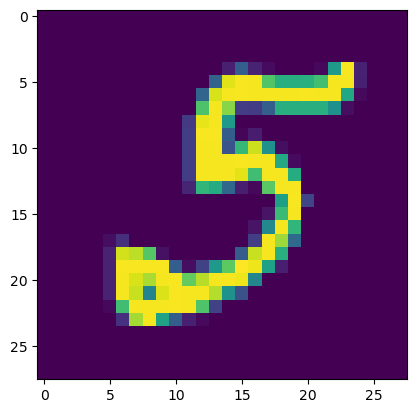

In [4]:
ind = 1
plt.imshow(train_images[ind])
print(f'Label: {train_labels[ind]}')
print(f'Image shape: {image_shape}')
print(f'Image middle row: {train_images[ind][image_side//2]}')

Перекодируем датасет в бинарные изображения и дальше будем работать с бинарными данными.

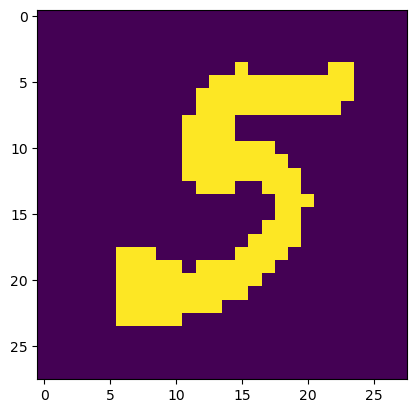

In [5]:
def plot_flatten_image(flatten_image, image_height=28):
    plt.imshow(flatten_image.reshape((image_height, -1)))

def to_binary_flatten_images(images):
    n_samples = images.shape[0]
    # flatten every image to vector
    images = images.reshape((n_samples, -1))
    # binary encoding: each image pixel is encoded either 0 or 1 depending on that image mean value
    images = (images >= images.mean(axis=1, keepdims=True)).astype(np.int8)
    return images


train_images = to_binary_flatten_images(train_images)
test_images = to_binary_flatten_images(test_images)
plot_flatten_image(train_images[ind])

## 02. Baseline: classifier on raw input

В качестве бейзлайна возьмем стандартный sklearn'овский логрег классификатор

In [6]:
LBFGS_MAX_ITER = 1_000

In [7]:
%%time

def test_bare_classification(x_tr,  y_tr, x_tst, y_tst):
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=1)
    linreg.fit(x_tr, y_tr)
    
    score = linreg.predict(x_tst) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}%')
    return score

np.random.seed(seed)
# for debug purposes I chose smaller subset of the train/test set, you can set the whole set of 60k training samples
n = 1_000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

# примерные/ориентировочные результаты
# 1k: 87.4; 888ms
# 60k: 91.4; 1.5min
_ = test_bare_classification(x_tr, y_tr, x_tst, y_tst)

Score: 87.4%
CPU times: total: 750 ms
Wall time: 267 ms


## 03. Spatial Pooler: skeleton

Временно сделаем пустой класс Spatial Pooler'а заглушку, чтобы дальше ввести весь необходимый auxiliary код для обучения и тестирования.

In [8]:
from tqdm import tqdm


class NoOpSpatialPooler:
    def __init__(self, input_size):
        self.input_size = input_size
        self.output_size = input_size
        
    def compute(self, dense_sdr, learn):
        # просто отдает вход на выход
        return np.flatnonzero(dense_sdr)
    
    def show(self):
        pass
        

np.random.seed(seed)
sp = NoOpSpatialPooler(train_images[0].size)
sparse_sdr = sp.compute(train_images[0], True)

print(sparse_sdr.size, sp.output_size)
assert sparse_sdr.size < sp.output_size

91 784


## 04. Train/test SP performance aux pipeline

Ниже непосредственно код для обучения и тестирования классификации с использованием Spatial Pooler'а. Общая схема следующая - мы обучаем SP на train set'е, а дальше SDR векторы на выходе из SP используем в кач-ве входных данных для логрег классификатора в надежде, что эти данные разделимы еще лучше, то есть что качество классификации улучшится.

__NB__: Не удивляйся, в реализации ниже обучение идет в немного полуонлайн режиме - делается небольшой претрейн, а потом полностью онлайн. Претрейн делаем для прогрева SP, тк на ранних стадиях обучения он слишком сильно меняет выходную кодировку.

In [9]:
%%time

def pretrain_sp(sp, images, n_samples):
    
    for img in images[:n_samples]:
        sp.compute(img, True)
    
def encode_to_csr_with_sp(images, sp, learn):
    flatten_encoded_sdrs = []
    indptr = [0]
    for img in tqdm(images):
        encoded_sparse_sdr = sp.compute(img, learn)
        flatten_encoded_sdrs.extend(encoded_sparse_sdr)
        indptr.append(len(flatten_encoded_sdrs))
#         if i % 100 == 0:
#             sp.show()

    data = np.ones(len(flatten_encoded_sdrs))
    csr = csr_matrix((data, flatten_encoded_sdrs, indptr), shape=(images.shape[0], sp.output_size))
    return csr

def test_classification_with_sp(x_tr,  y_tr, x_tst, y_tst, sp):
    # a small pretrain SP before real work
    pretrain_sp(sp, x_tr, n_samples=1000)
    
    # encode images and continuously train SP
    csr = encode_to_csr_with_sp(x_tr, sp, learn=True)
    
    # train linreg
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=3)
    linreg.fit(csr, y_tr)
    
    # encode test images (without SP learning) and then test score
    csr = encode_to_csr_with_sp(x_tst, sp, False)
    score = linreg.predict(csr) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}% for n = {len(x_tr)}')
    return score

n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]
my_sp = NoOpSpatialPooler(train_images[0].size)

# 87.3; 1.16s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, my_sp)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 124971.81it/s]

Score: 87.4% for n = 1000
CPU times: total: 15.6 ms
Wall time: 1.69 s


0.874

## 05. Spatial Pooler: learning

__Здесь начинается практическое задание__

В этой части требуется реализовать простую версию SP с обучением как описано в видео htm scool до бустинга (т.е. бустинг пока не нужен).

In [43]:
import scipy.stats as sps
from IPython.display import clear_output
import time

class LearnableSpatialPooler:
    def __init__(
        self, input_size, output_size, permanence_threshold, output_sparsity, 
        synapse_permanence_deltas, receptive_field_sparsity
    ):
        '''
        params:
            `input_size` - the size of the input SDR
            `output_size` - the size of the output SDR
            `permanence_threshold` - value in [0, 1], defines whether or not a connection is active
            `output_sparsity` - value in [0, 1], defines desired output SDR sparsity, e.g. 0.02 is 2% sparsity
            `synapse_permanence_deltas` - tuple of (p+, p-), defines permanence increment/decrement for learning
            `receptive_field_sparsity` - value in [0, 1], defines the fraction of _potential_ synapses
        '''
        self.input_size = input_size
        self.output_size = output_size
        
        self.permanence_threshold = permanence_threshold
        self.output_sparsity = output_sparsity
        self.synapse_permanence_deltas = synapse_permanence_deltas
        self.receptive_field_sparsity = receptive_field_sparsity  
        
        self.num_connections = int(input_size * receptive_field_sparsity)
        
        self.k = int(output_size * output_sparsity)
        
        self.connect_inds = np.array([np.random.choice(np.arange(self.input_size), 
                                         size=self.num_connections, replace=False) for _ in range(self.output_size)])
        
        stdv = 1./np.sqrt(self.output_size)
        self.permanences = np.random.uniform(permanence_threshold-stdv, permanence_threshold+stdv, 
                                             size=(self.output_size, self.num_connections))
        self.being_activated = []
        
    def reset_statistics(self):
        self.being_activated = []
        
    def show(self):
        active = self.activated_cols
        clear_output()
        arr = np.zeros(self.output_size)
        arr[active] = 1
        plt.imshow(arr.reshape(int(np.sqrt(self.output_size)), -1))
        plt.show()
        
        
    def compute(self, dense_sdr, learn):
        '''
        params:
            `dense_sdr` - input SDR in dense for, i.e. as np.array
            `learn` - bool flag, whether or not to do a learning step
        
        returns:
            a list of activated columns indices
        '''
        
        # TODO: compute and learn
        active_input_mask = (self.permanences > self.permanence_threshold).astype(np.int8)
        p_plus, p_minus = self.synapse_permanence_deltas
        
        overlaps = np.sum(dense_sdr[self.connect_inds] * active_input_mask, axis=1)
#         overlaps = [] 
#         for i in range(len(self.connect_inds)):
#             active_inds = self.connect_inds[i][active_input_mask[i]]
#             active_input = dense_sdr[active_inds]
#             overlap = np.sum(active_input)
#             overlaps.append(overlap)
            
        #overlaps    = np.array(overlaps)
        activated_cols = np.argsort(overlaps)[::-1][:self.k]
        self.being_activated.extend(activated_cols.tolist())
        
        
        if learn:
            for ind in activated_cols:
                input_inds = self.connect_inds[ind]                      # inds num_connections size
                input_overlap_inds    = input_inds[dense_sdr[input_inds] == 1]
                overlap_inds    = np.where(np.isin(self.connect_inds[ind], input_overlap_inds   ))[0]
                # disconnect_inds = np.where(np.isin(self.connect_inds[ind], input_disconnect_inds))[0]
                self.permanences[ind][overlap_inds] += p_plus + p_minus
                self.permanences[ind] -= p_minus

            self.permanences = np.clip(self.permanences, 0, 1)

        self.activated_cols = activated_cols
        
        self.n_active_bits = len(activated_cols)
        # make sure that activated_cols is array of indices, not a whole binary vector
        return activated_cols

        
np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=10**2,
    permanence_threshold=0.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.01, .03),
    receptive_field_sparsity=.8
)
sparse_sdr = sp.compute(train_images[0], True)

print(sparse_sdr.size, sp.output_size, sp.n_active_bits)
assert sparse_sdr.size == sp.n_active_bits
sparse_sdr

4 100 4


array([22, 30, 44, 71], dtype=int64)

In [783]:
np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=10**2,
    permanence_threshold=0.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.06, .03),
    receptive_field_sparsity=.8
)

for i in range(10):
    sp.compute(train_images[0], True)
    print(sp.permanences[22][60:66])

[0.47337718 0.46490907 0.45104001 0.5640866  0.63017347 0.48509768]
[0.44337718 0.43490907 0.42104001 0.5340866  0.69017347 0.45509768]
[0.41337718 0.40490907 0.39104001 0.5040866  0.75017347 0.42509768]
[0.38337718 0.37490907 0.36104001 0.4740866  0.81017347 0.39509768]
[0.35337718 0.34490907 0.33104001 0.4440866  0.87017347 0.36509768]
[0.32337718 0.31490907 0.30104001 0.4140866  0.93017347 0.33509768]
[0.29337718 0.28490907 0.27104001 0.3840866  0.99017347 0.30509768]
[0.26337718 0.25490907 0.24104001 0.3540866  1.         0.27509768]
[0.23337718 0.22490907 0.21104001 0.3240866  1.         0.24509768]
[0.20337718 0.19490907 0.18104001 0.2940866  1.         0.21509768]


In [780]:
print(sp.connect_inds[22, 63])
print(sp.connect_inds[22, 64])

114
324


In [782]:
train_images[0][114], train_images[0][324]

(0, 1)

In [42]:
inputs = np.random.randint(0, 2, size=10)


mask = np.array([[0, 1, 0],
                 [0, 0, 0]])

rfs = np.array([[0, 1, 5],
                [4, 7, 8]])

print(inputs)
np.sum(inputs[rfs] * mask, axis=1)

[0 1 0 1 1 1 1 0 1 1]


array([1, 0])

### 05.1. Naive SP performance

Проверь качество работы своей реализации. В комментариях примерные значения для разных `n`, на которые можно попробовать ориентироваться:

In [44]:
%%time

np.random.seed(seed)
n = 60000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = LearnableSpatialPooler(
    input_size=train_images[0].size, 
    output_size=30**2,
    permanence_threshold=0.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.03, .03),
    receptive_field_sparsity=.8
)
sp.reset_statistics()
# my 60k 86.9, 11min 14s
# 1k: 80.2; 2.98s
# 60k: 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 466.51it/s]

Score: 86.9% for n = 60000
CPU times: total: 5min 10s
Wall time: 6min 57s


0.8688

Интересная метрика оценки качества работы SP и вырожденности датасета - энтропия выходных активаций.

Добавь либо в реализацию класса, либо где-то сбоку возможность учета статистики активаций выходных клеток (ты наверняка заметил, что обычно их контринтуитивно называют столбцами, что оч круто запутывает) и функцию подсчета энтропии на основе этой статистики. Собери такую статистику на одном прогоне на всем датасете и:

- нарисуй гистограмму частоты активаций (с нормализацией, чтобы по оси Y были вероятности активации, а не их число)
- посчитай энтропию $H = -\sum p \cdot \log p$

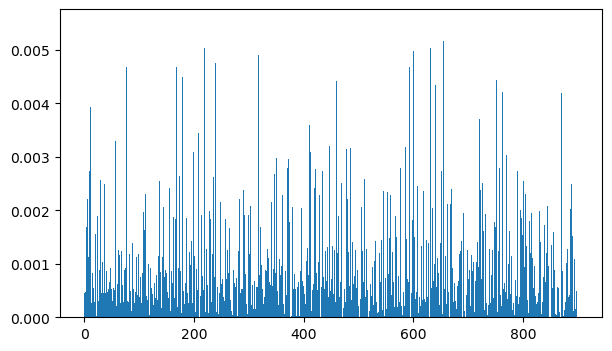

In [34]:
noboosting_stats = sp.being_activated

plt.figure(figsize=(7, 4))
noboosting_data = plt.hist(noboosting_stats, bins=sp.output_size, density=True);

In [35]:
p = noboosting_data[0]
H = -1 * np.sum(p * np.log(p))
H

6.394748867644119

In [36]:
frequences = []
for i in tqdm(range(900)):
    count = np.sum(np.array(noboosting_stats) == i)
    frequences.append(count / len(noboosting_stats))

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [02:15<00:00,  6.62it/s]


In [37]:
def my_hist(x, bins, as_ratio=False):
    x = np.array(x)
    mn = min(x)
    mx = max(x)
    step = (mx - mn) / bins
    
    current = mn
    mean_freqs = []
    counts = []

    for i in range(bins):
        mask = (x >= current) * (x < (current + step))
        count = mask.sum()
        if count == 0:
            mean_freq = 0
        else:
            mean_freq = x[mask].mean()
        counts.append(count)
        mean_freqs.append(mean_freq)
        current += step

    counts = np.array(counts)
    if as_ratio:
        return mean_freqs, counts / counts.sum(), step
    return mean_freqs, counts, step

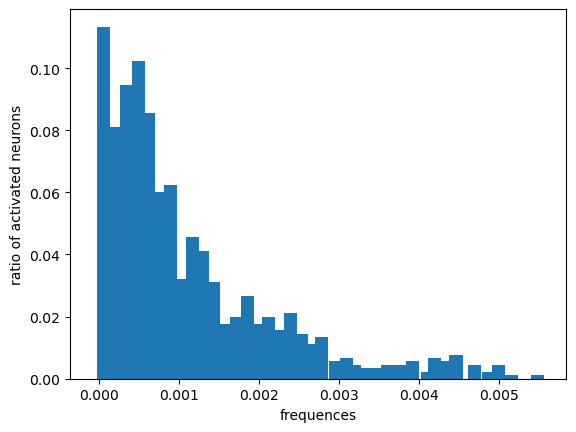

In [38]:
mean_freqs, ratios, step = my_hist(frequences, bins=40, as_ratio=True)

plt.bar(mean_freqs, ratios, width=step*1.2)
plt.xlabel("frequences")
plt.ylabel('ratio of activated neurons');

In [39]:
p = np.array(frequences)
H = -1 * np.sum(p * np.log(p))
H

6.388755319977214

Теперь давай посмотрим, как выходной размер `output_size` влияет на качество работы. Протестируй разные значения `output_size` - например, $[10^2, 15^2,..., 55^2, 60^2]$ и отрисуй график зависимости [качества классификации, но можешь и времени работы тоже].

_Можно для начала прикинуть для n=1000 и двигаться дальше, а позже пересчитать на всем датасете_

In [19]:
n = 1000
out_sizes = np.arange(10, 61, 5) ** 2
noboost_results = []
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

for out_size in out_sizes:
    np.random.seed(seed)
    sp = LearnableSpatialPooler(
        input_size=train_images[0].size, 
        output_size=out_size,
        permanence_threshold=0.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.03, .03),
        receptive_field_sparsity=.8
    )
    sp.reset_statistics()
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
    noboost_results.append(res)
    clear_output()

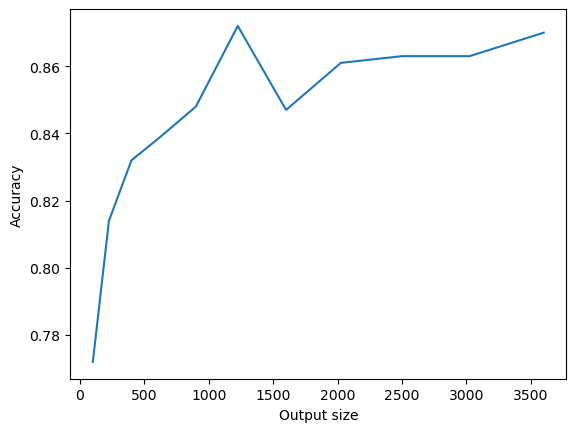

In [21]:
plt.plot(out_sizes, noboost_results)
plt.xlabel("Output size")
plt.ylabel("Accuracy");

## 06. Spatial Pooler: boosting

В этом пункте требуется реализовать бустинг. Обрати внимание, в видео htm school речь ведется о бустинге overlap score на основе активности выходных ячеек -  именно такой вид бустинга и нужно реализовать. Еще есть бустинг значений permanence синапсов выходных ячеек, имеющих слишком низкое среднее значение overlap score за последние N итераций - рассмотрение этого вида бустинга оставим в стороне. Так что дальше под бустингом будет иметься в виду только первый вариант.

Зададим параметр `max_boost_factor` $\in [0, +\infty)$. Можно по-разному задавать интерпретацию этого параметра, то есть как будет действовать бустинг. Например, можно дать возможность бустингу работать только в сторону усиления слабых — тогда параметр `max_boost_factor` $=K$ определяет, что значения overlap score под действием бустинга могут быть увеличены максимум в $1+K$ раз. То есть `max_boost_factor`$=1$ означает, что оверлапы могут быть увеличены максимум в два раза, а 0 — что бустинг отключен.

Однако допустима и реализация, в которой бустинг работает в обе стороны — слабые колонки усиливает, а сильные наоборот ослабляет, и тогда пределы изменения для величины `max_boost_factor` $=K$: $[\frac{1}{K}, K]$, то есть бустинг может и усилить, и ослабить максимум в $K$ раз. В своей реализации выбери любой из этих вариантов.

In [51]:
class BoostedSpatialPooler:
    def __init__(
        self, input_size, output_size, permanence_threshold, output_sparsity, synapse_permanence_deltas, receptive_field_sparsity,
        max_boost_factor, boost_sliding_window
    ):
        '''
        params:
            `input_size` - the size of the input SDR
            `output_size` - the size of the output SDR
            `permanence_threshold` - value in [0, 1], defines whether or not a connection is active
            `output_sparsity` - value in [0, 1], defines desired output SDR sparsity, e.g. 0.02 is 2% sparsity
            `synapse_permanence_deltas` - tuple of (p+, p-), defines permanence increment/decrement for learning
            `receptive_field_sparsity` - value in [0, 1], defines the fraction of _potential_ synapses
            `max_boost_factor` - value in [0, +inf), defines maximum allowed boosting. Boosting value X > 0 (X < 0) means that overlap is multiplied (divided) by `1 + X`.
            `boost_sliding_window` - value in [1, +inf), defines the size of the window for moving avg output column activity
        '''
        self.input_size = input_size
        self.output_size = output_size
        
        self.permanence_threshold = permanence_threshold
        self.output_sparsity = output_sparsity
        self.synapse_permanence_deltas = synapse_permanence_deltas
        self.receptive_field_sparsity = receptive_field_sparsity  
        
        self.num_connections = int(input_size * receptive_field_sparsity)
        
        self.k = int(output_size * output_sparsity)
        
        self.connect_inds = np.array([np.random.choice(np.arange(self.input_size), 
                                         size=self.num_connections, replace=False) for _ in range(self.output_size)])
        
        stdv = 1./np.sqrt(self.output_size)
        self.permanences = np.random.uniform(permanence_threshold-stdv, permanence_threshold+stdv, 
                                             size=(self.output_size, self.num_connections))
        
        self.max_boost_factor = max_boost_factor
        self.T = boost_sliding_window
        self.mean_acts = np.zeros(self.output_size)
        self.curr_acts = np.zeros(self.output_size)
        self.boosting_factors = np.ones(self.output_size)
        self.beta = 1
        
        self.being_activated = []
        
        
    def reset_statistics(self):
        self.being_activated = []
        
        
    def compute_average(self, current):
        self.mean_acts = ((self.T - 1) * self.mean_acts + current) / self.T
        
    def compute_neighbours_activity(self):
        return (np.sum(self.mean_acts) - self.mean_acts) / (self.mean_acts.shape[0] - 1)
    
    def compute_boosting_coefs(self):
        K = self.max_boost_factor
        boost = np.exp(- self.beta * (self.mean_acts - self.compute_neighbours_activity()))
        self.boosting_factors = np.clip(boost, 1/K, K)
        
        
    def show(self):
        active = self.activated_cols
        clear_output()
        arr = np.zeros(self.output_size)
        arr[active] = 1
        plt.imshow(arr.reshape(int(np.sqrt(self.output_size)), -1))
        plt.show()
        
        
    def compute(self, dense_sdr, learn):
        '''
        params:
            `dense_sdr` - input SDR in dense for, i.e. as np.array
            `learn` - bool flag, whether or not to do a learning step
        
        returns:
            a list of activated columns indices
        '''
        
        # TODO: compute and learn
        active_input_mask = self.permanences > self.permanence_threshold
        p_plus, p_minus = self.synapse_permanence_deltas
#         overlaps = []
        
        self.compute_average(self.curr_acts)
        self.compute_boosting_coefs()
        overlaps = np.sum(dense_sdr[self.connect_inds] * active_input_mask, axis=1) * self.boosting_factors

#         for i in range(len(self.connect_inds)):
#             active_inds = self.connect_inds[i][active_input_mask[i]]
#             active_input = dense_sdr[active_inds]
#             overlap = np.sum(active_input) * self.boosting_factors[i]
#             overlaps.append(overlap)
            
        overlaps    = np.array(overlaps)
        activated_cols = np.argsort(overlaps)[::-1][:self.k]
        self.curr_acts = np.zeros(self.output_size)
        self.curr_acts[activated_cols] = 1
        self.being_activated.extend(activated_cols.tolist())
        
        
        if learn:
            for ind in activated_cols:
                input_inds = self.connect_inds[ind]                      # inds num_connections size
                input_overlap_inds    = input_inds[dense_sdr[input_inds] == 1]
                overlap_inds    = np.where(np.isin(self.connect_inds[ind], input_overlap_inds   ))[0]
                # disconnect_inds = np.where(np.isin(self.connect_inds[ind], input_disconnect_inds))[0]
                self.permanences[ind][overlap_inds] += p_plus + p_minus
                self.permanences[ind] -= p_minus

            self.permanences = np.clip(self.permanences, 0, 1)

        self.activated_cols = activated_cols
        
        self.n_active_bits = len(activated_cols)
        # make sure that activated_cols is array of indices, not a whole binary vector
        return activated_cols
        

np.random.seed(seed)
my_sp = BoostedSpatialPooler(
    train_images[0].size, output_size=10**2, permanence_threshold=.5, output_sparsity=.04, synapse_permanence_deltas=(.1, .02), 
    receptive_field_sparsity=.8, max_boost_factor=0.5, boost_sliding_window=1000
)
my_sp.compute(train_images[0], True)

array([22, 30, 44, 71], dtype=int64)

### 06.1. SP with boosting performance

_Дальше все как и в пункте 05.1_

Проверь качество работы своей реализации. В комментариях по-прежнему примерные значения для разных `n`, на которые можно попробовать ориентироваться:

In [52]:
%%time

np.random.seed(seed)
n = 60000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = BoostedSpatialPooler(
    input_size=train_images[0].size, 
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.03, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 1k: 84.0; 3.24 s
# 60k: 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 471.06it/s]


Score: 88.2% for n = 60000
CPU times: total: 5min 3s
Wall time: 6min 32s


0.882

- нарисуй гистограмму вероятностей активаций
- посчитай энтропию $H = -\sum p \cdot \log p$
- сравни с результатами без бустинга - есть какие-то очевидные выводы?

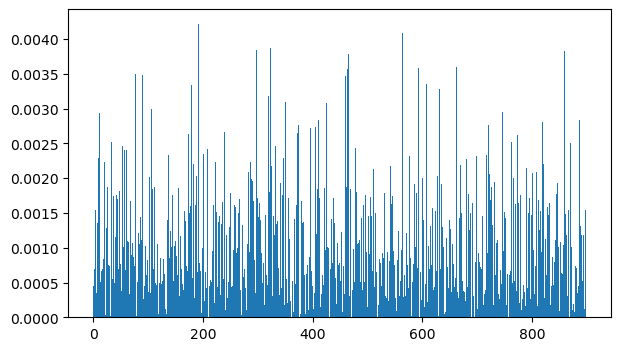

In [23]:
boosting_stats = sp.being_activated

plt.figure(figsize=(7, 4))
boosting_data = plt.hist(boosting_stats, bins=sp.output_size, density=True);

In [40]:
p = boosting_data[0]
H = -1 * np.sum(p * np.log(p))
H

6.523860879440307

In [41]:
frequences = []
for i in tqdm(range(900)):
    count = np.sum(np.array(boosting_stats) == i)
    frequences.append(count / len(boosting_stats))

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:52<00:00,  8.02it/s]


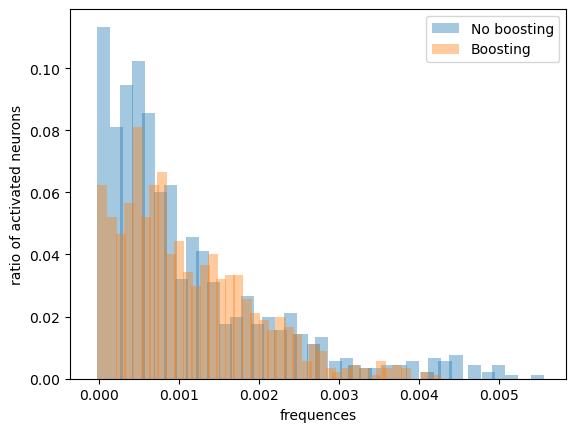

In [43]:
b_mean_freqs, b_ratios, b_step = my_hist(frequences, bins=40, as_ratio=True)

plt.bar(mean_freqs, ratios, width=step*1.2, label='No boosting', alpha=0.4)
plt.bar(b_mean_freqs, b_ratios, width=b_step*1.2, label='Boosting', alpha=0.4)
plt.legend()
plt.xlabel("frequences")
plt.ylabel('ratio of activated neurons');

Протестируй разные значения `output_size` - например, $[10^2, 15^2,..., 55^2, 60^2]$ и отрисуй график зависимости [качества классификации, но можешь и времени работы тоже].

Сравни с результатами без бустинга

In [50]:
p = np.array(frequences)
H = -1 * np.sum(p * np.log(p))
H

6.517723873982513

In [16]:
n = 1000
out_sizes = np.arange(10, 61, 5) ** 2
boost_results = []
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

for out_size in out_sizes:
    np.random.seed(seed)
    sp = BoostedSpatialPooler(
        input_size=train_images[0].size, 
        output_size=out_size,
        permanence_threshold=.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.03, .03),
        receptive_field_sparsity=.8,
        max_boost_factor=2,
        boost_sliding_window=1000
    )
    sp.reset_statistics()
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
    boost_results.append(res)
    clear_output()

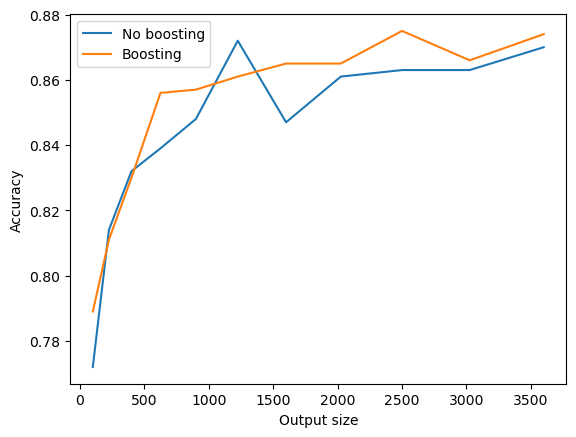

In [22]:
plt.plot(out_sizes, noboost_results, label="No boosting")
plt.plot(out_sizes, boost_results, label="Boosting")
plt.legend()
plt.xlabel("Output size")
plt.ylabel("Accuracy");

___
__[Опционально]__ можешь ради интереса поиграться с таким параметром как `receptive_field_sparsity`. Возьми в качестве выходного размера `output_size` = $50^2$ и проверь результаты на разных значениях параметра $[0.4, 0.5, ..., 1.0]$ и построй график зависимости.

In [23]:
n = 1000
out_size = 50**2
rf_sparsities = np.arange(0.4, 1.1, 0.1)
rfs_results = []
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

for rf_spars in rf_sparsities:
    np.random.seed(seed)
    sp = BoostedSpatialPooler(
        input_size=train_images[0].size, 
        output_size=out_size,
        permanence_threshold=.5,
        output_sparsity=.04,
        synapse_permanence_deltas=(.03, .03),
        receptive_field_sparsity=rf_spars,
        max_boost_factor=2,
        boost_sliding_window=1000
    )
    sp.reset_statistics()
    res = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
    rfs_results.append(res)
    clear_output()

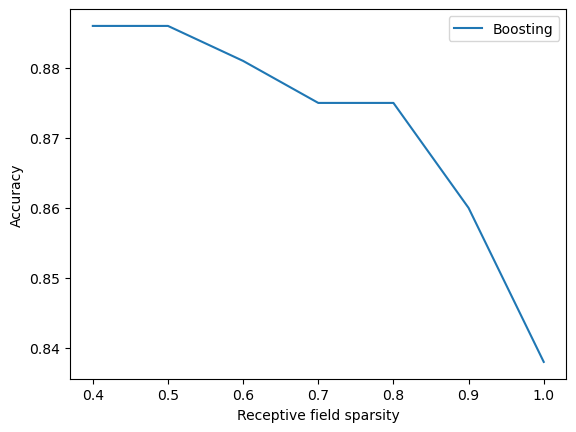

In [24]:
plt.plot(rf_sparsities, rfs_results, label="Boosting")
plt.legend()
plt.xlabel("Receptive field sparsity")
plt.ylabel("Accuracy");

## 07. TESTING

Дальше просто сравнительное тестирование получившихся результатов.

In [44]:
n = 60000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

In [45]:
%%time

def test_bare_classification(x_tr,  y_tr, x_tst, y_tst):
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=3)
    linreg.fit(x_tr, y_tr)
    
    score = linreg.predict(x_tst) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}%')
    return score

np.random.seed(seed)
# 92.11; 38s
test_bare_classification(x_tr, y_tr, x_tst, y_tst)

Score: 91.4%
CPU times: total: 297 ms
Wall time: 2min 41s


0.9143

In [46]:
%%time

np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size, 
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
)
# 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:07<00:00, 147.88it/s]

Score: 76.2% for n = 60000
CPU times: total: 9min 38s
Wall time: 12min 33s


0.7621

In [47]:
%%time

np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size, 
    output_size=50**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
)
# 93.15; 221 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:13<00:00, 51.76it/s]


Score: 80.9% for n = 60000
CPU times: total: 26min 3s
Wall time: 34min 30s


0.8094

In [48]:
%%time

np.random.seed(seed)
sp = BoostedSpatialPooler(
    input_size=train_images[0].size, 
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.46it/s]


Score: 86.4% for n = 60000
CPU times: total: 10min 1s
Wall time: 12min 26s


0.8641

In [49]:
%%time

np.random.seed(seed)
sp = BoostedSpatialPooler(
    input_size=train_images[0].size, 
    output_size=50**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 94.44; 238 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:52<00:00, 34.13it/s]


Score: 89.4% for n = 60000
CPU times: total: 13min 47s
Wall time: 43min 56s


0.8936

## Improve SP implementation

Теперь, когда у тебя есть готовая реализация SpatialPooler, время для улучшения/ускорения реализации. Попробуй выполнить задания ниже.

1. **Векторизация**: нужна векторизованная реализация, которая будет эффективно вычислять overlap score, boosting и все остальное. Важно ответить себе на вопрос, как организовать хранение рецептивных полей нейронов SP, как делать pattern matching для входного паттерна, как эффективно делать шаг обновления. Придется поиграться с разными реализациями, измеряя скорость их работы. Ну и вообще, сейчас самое время причесать свою реализациюи довести ее до финального вида.

2. **Разреженные рецептивные поля**: можно ли улучшить качество работы SP, если уменьшить размеры рецептивных полей его нейронов (но возможно увеличив количество нейронов)? Зафиксируй какое-нибудь определенный лимит времени работы SP и попробуй варьировать эти два гиперпараметра (`receptive_field_sparsity` и `output_size`), чтобы оставаться в рамках лимита. Нарисуй график зависимости качества от этих двух параметров.

3. [**СЛОЖНО**] **Newborn-stage**: В [On the importance of the newborn stage when learning patterns with the Spatial Pooler](https://link.springer.com/article/10.1007/s42979-022-01066-4) описана идея, что бустинг, вообще говоря, имеет и негативную сторону — он имеет смысл лишь на ранних стадиях формирования рецептивных полей нейронов. Но далее он только влечет к нестабильности (способствует дрифту кодировки на выходе из SP за счет переучивания его нейронов). Предлагается взять эту идею (статью подробно читать для этого не нужно) и добавить newborn stage в SP. Для этого сделай отдельную реализацию, чтобы у тебя была отдельная финальная версия без этой фичи, и отдельная уже с. Newborn stage будет разделен на K этапов, в процессе которых
    1. Бустинг будет постепенно снижаться (например, линейно) к нулю
    2. Рецептивные поля будут уменьшаться. Таким образом SP будет инициализироваться с большими рецептивными полями, но в процессе newborn stage они будут постепенно пруниться до целевых значений. Это позволит нам во взрослой стадии иметь быстрый (за счет маленьких рецептивных полей) SP с хорошо настроенными рецептивными полями, из-за чего качество будет не сильно хуже, чем если бы мы не прунили.
   
   Протестируй данную реализацию с разными настройками начального и конечного размера рецептивных полей.